In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import date, timedelta

import numpy as np
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting

import scenario_generator.utils as u
import scenario_generator.curated as curated

In [53]:
save_dir = '/Users/kiran/Documents/baseline_project'
os.makedirs(save_dir, exist_ok=True)

In [70]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 7, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*8
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-03 2031-07-01


In [71]:
offline_data.keys()

dict_keys(['rb_power_zero', 'qa_power_zero', 'historical_raw_power_eib', 'historical_qa_power_eib', 'historical_onboarded_qa_power_pib', 'historical_renewed_qa_power_pib', 'rb_known_scheduled_expire_vec', 'qa_known_scheduled_expire_vec', 'known_scheduled_pledge_release_full_vec', 'start_vested_amt', 'zero_cum_capped_power_eib', 'init_baseline_eib', 'circ_supply_zero', 'locked_fil_zero', 'daily_burnt_fil', 'burnt_fil_vec', 'historical_renewal_rate'])

In [72]:
baseline = minting.compute_baseline_power_array(
    np.datetime64(start_date), np.datetime64(end_date), offline_data['init_baseline_eib'],
)

In [73]:
# get historical RBP, RR, FPR for last 180 days to setup simulation trajectories
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(start_date-timedelta(days=180), start_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(start_date-timedelta(days=180), start_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(start_date-timedelta(days=180), start_date)

<IPython.core.display.Javascript object>


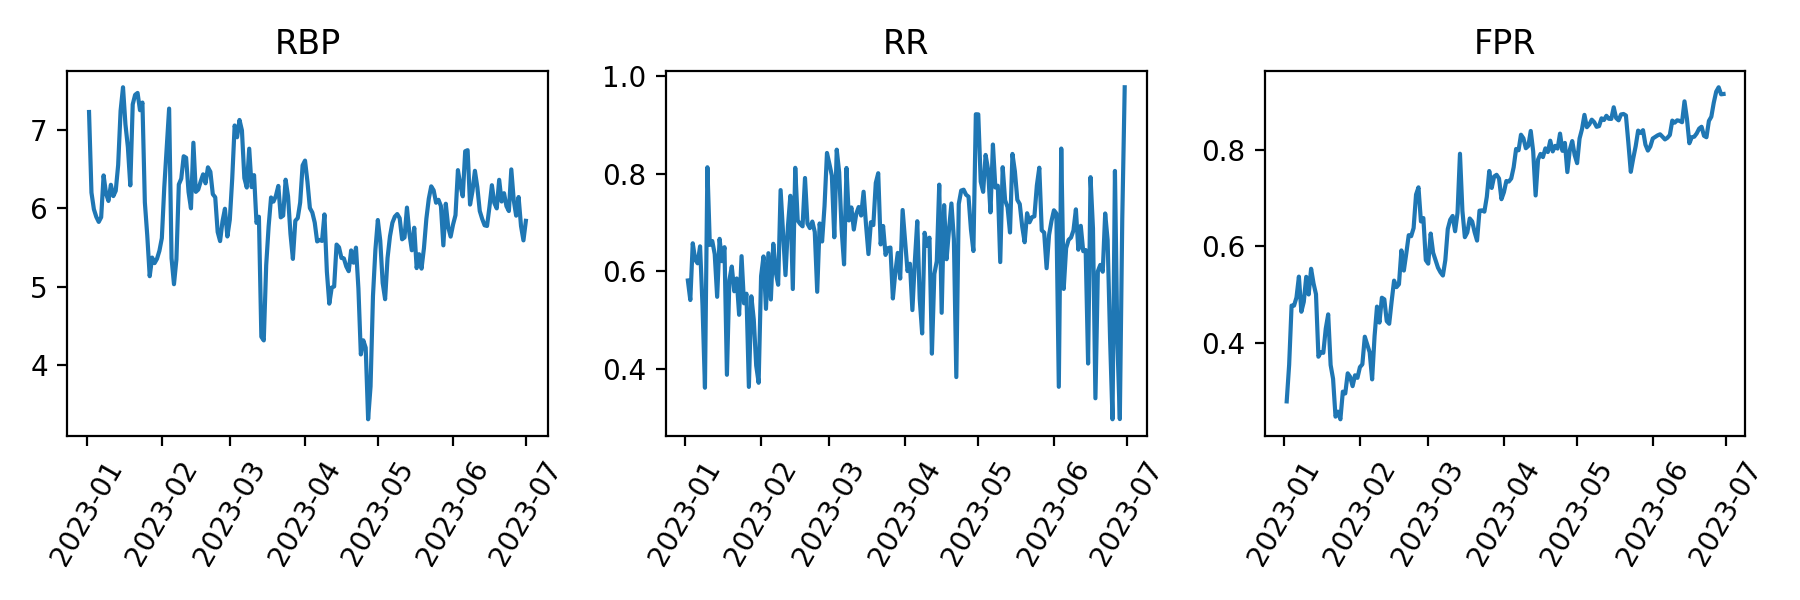

In [74]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.plot(t_hist_rbp, hist_rbp)
plt.xticks(rotation=60)
plt.title('RBP')

plt.subplot(1,3,2)
plt.plot(t_hist_rr, hist_rr)
plt.xticks(rotation=60)
plt.title('RR')

plt.subplot(1,3,3)
plt.plot(t_hist_fpr, hist_fpr)
plt.xticks(rotation=60)
plt.title('FPR')

plt.tight_layout()

In [75]:
lock_target = 0.3
sector_duration=360

In [76]:
# create scenarios
smoothed_last_historical_rbp = np.median(hist_rbp[-30:])
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])

print(smoothed_last_historical_rbp, smoothed_last_historical_rr, smoothed_last_historical_fpr)

g = np.log(2)/(365)
scenarios = {
    'status_quo': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*2,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    'linear_ramp': {
        'rbp': curated.linear_increase_and_plateau(
            smoothed_last_historical_rbp,
            smoothed_last_historical_rbp * 10,
            forecast_length,
            forecast_length
        ),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    'exponential_ramp': {
        'rbp': smoothed_last_historical_rbp*np.exp(g*np.arange(forecast_length)),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
}

colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]

6.078338623046875 0.6556211653492354 0.8463964328958687


<IPython.core.display.Javascript object>


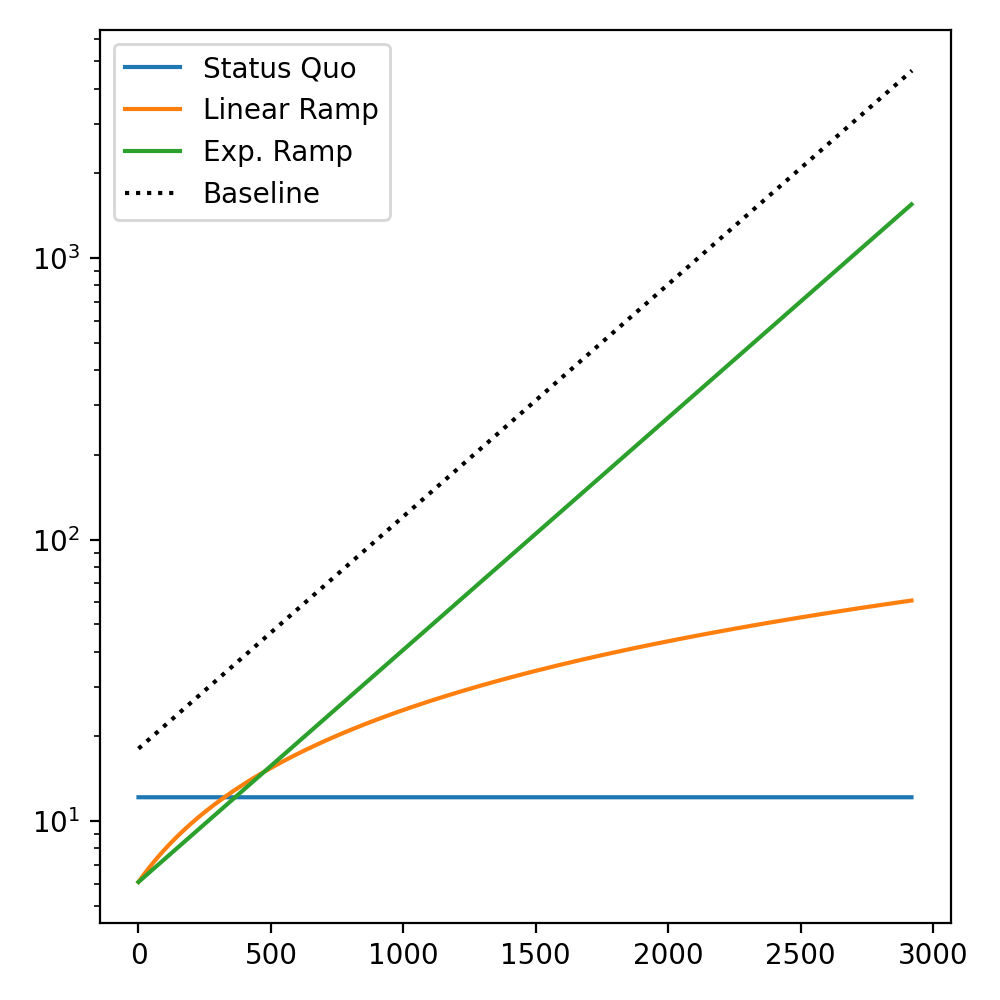

In [77]:
# plot the RBP trajectories for comparison
plt.figure(figsize=(5,5))
plt.plot(scenarios['status_quo']['rbp'], label='Status Quo')
plt.plot(scenarios['linear_ramp']['rbp'], label='Linear Ramp')
plt.plot(scenarios['exponential_ramp']['rbp'], label='Exp. Ramp')
plt.plot(baseline, linestyle=':', color='k', label='Baseline')
plt.legend()
plt.yscale('log')
plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'rbp_trajectories.png'))

In [78]:
# run JAX simulation
scenario2results = {}
for scenario_name, trajectories in scenarios.items():
    
    rbp = jnp.array(trajectories['rbp'])
    rr = jnp.array(trajectories['rr'])
    fpr = jnp.array(trajectories['fpr'])
    
    # simulation_results, jax_supply_inputs, jax_rb_power_forecast, jax_qa_power_forecast, jax_power_inputs = sim.run_sim(
    simulation_results = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    scenario2results[scenario_name] = simulation_results

total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]

In [79]:
keys = list(scenarios.keys())
def plot_x(ax, results, key, labels, colors, scale_by=1):
    for ii, scenario in enumerate(keys):
        res = results[scenario]
        ax.plot(t, res[key]/scale_by, label=labels[ii], color=colors[ii])
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

<IPython.core.display.Javascript object>


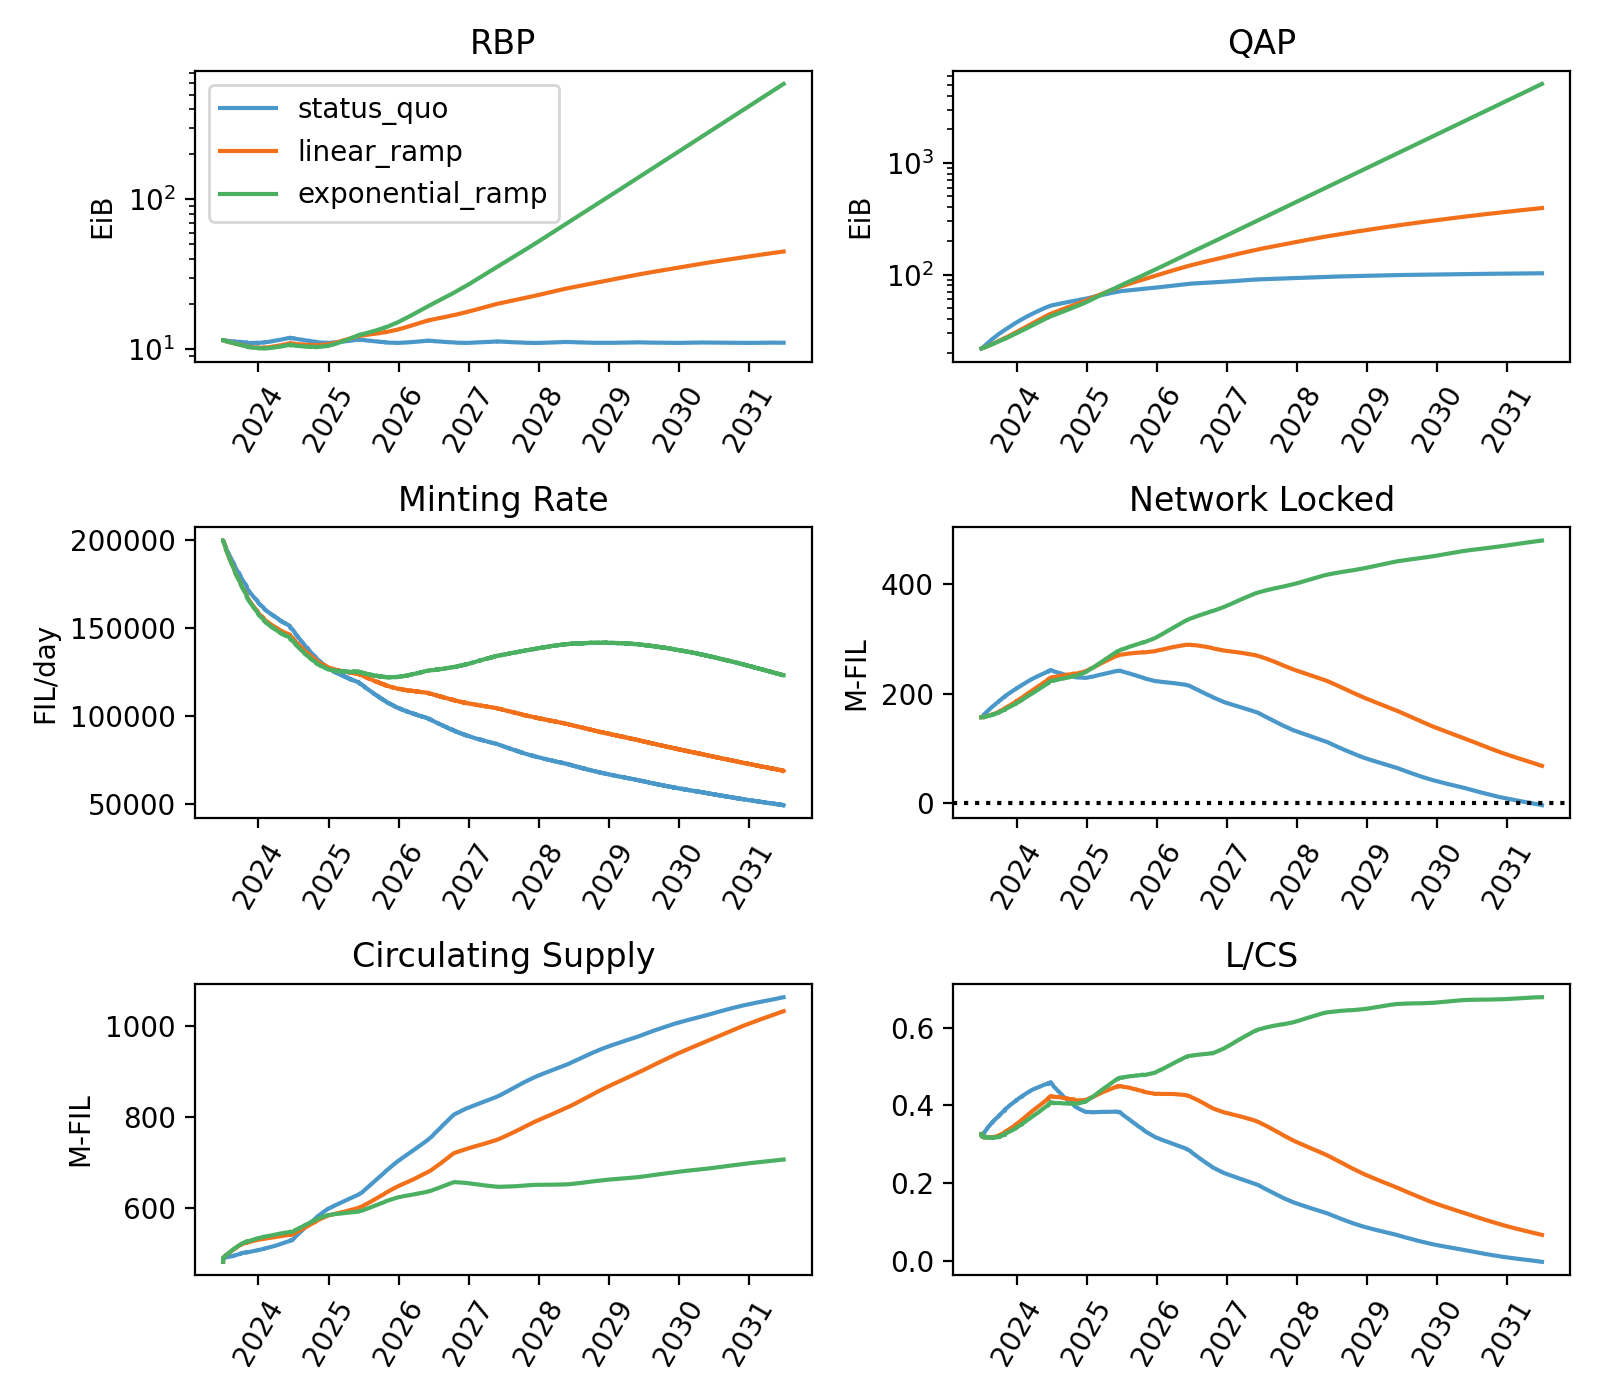

In [80]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,7))

c_vec = [c(0.6) for c in colors]

axx = ax[0,0]
plot_x(axx, scenario2results, 'rb_total_power_eib', keys, c_vec)
axx.set_yscale('log')
axx.set_ylabel('EiB')
axx.set_title('RBP')
axx.legend()

axx = ax[0,1]
plot_x(axx, scenario2results, 'qa_total_power_eib', keys, c_vec)
axx.set_yscale('log')
axx.set_ylabel('EiB')
axx.set_title('QAP')

axx = ax[1,0]
plot_x(axx, scenario2results, 'day_network_reward', keys, c_vec)
axx.set_ylabel('FIL/day')
axx.set_title('Minting Rate')

axx = ax[1,1]
plot_x(axx, scenario2results, 'network_locked', keys, c_vec, scale_by=1e6)
axx.set_ylabel('M-FIL')
axx.set_title('Network Locked')
axx.axhline(0, linestyle=':', color='k')

axx = ax[2,0]
plot_x(axx, scenario2results, 'circ_supply', keys, c_vec, scale_by=1e6)
axx.set_ylabel('M-FIL')
axx.set_title('Circulating Supply')

axx = ax[2,1]
for ii, scenario in enumerate(keys):
    res = scenario2results[scenario]
    axx.plot(t, res['network_locked']/res['circ_supply'], label=keys[ii], color=c_vec[ii])
for tick in axx.get_xticklabels():
    tick.set_rotation(60)
axx.set_title('L/CS')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'locked_trajectories.png'))

In [81]:
# cross-check w/ numpy for the status-quo simulation
np_df = np_sim.run_simple_sim(
    start_date,
    current_date,
    forecast_length,
    scenarios['status_quo']['rr'],
    scenarios['status_quo']['rbp'],
    scenarios['status_quo']['fpr'],
    sector_duration,
    token
)

<IPython.core.display.Javascript object>


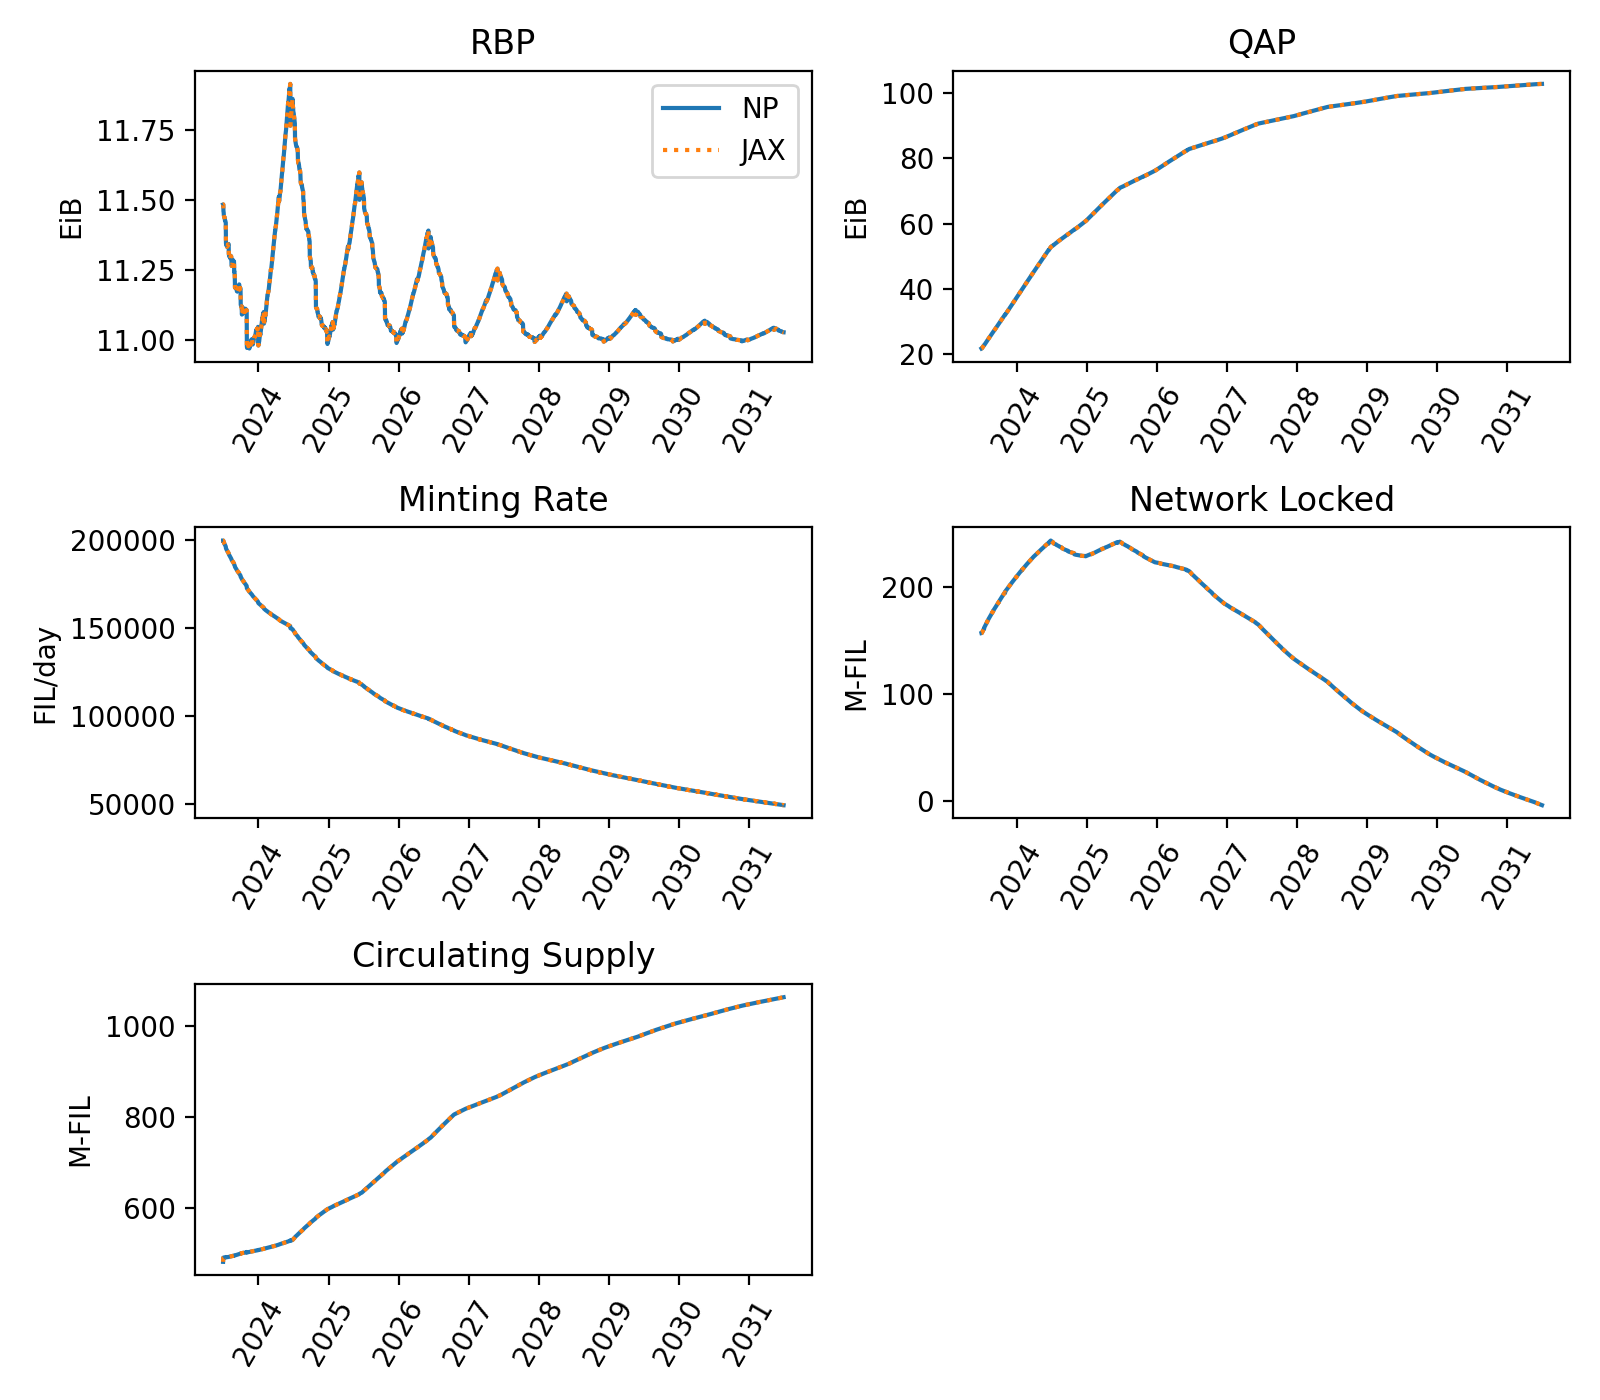

In [82]:
plt.figure(figsize=(8,7))

plt.subplot(3,2,1)
plt.plot(np_df['date'], np_df['network_RBP']/C.EXBI, label='NP')
plt.plot(t, scenario2results['status_quo']['rb_total_power_eib'], label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('RBP')
plt.legend()

plt.subplot(3,2,2)
plt.plot(np_df['date'], np_df['network_QAP']/C.EXBI, label='NP')
plt.plot(t, scenario2results['status_quo']['qa_total_power_eib'], label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('QAP')

plt.subplot(3,2,3)
plt.plot(np_df['date'], np_df['day_network_reward'], label='NP')
plt.plot(t, scenario2results['status_quo']['day_network_reward'], label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')

plt.subplot(3,2,4)
plt.plot(np_df['date'], np_df['network_locked']/1e6, label='NP')
plt.plot(t, scenario2results['status_quo']['network_locked']/1e6, label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('M-FIL')

plt.subplot(3,2,5)
plt.plot(np_df['date'], np_df['circ_supply']/1e6, label='NP')
plt.plot(t, scenario2results['status_quo']['circ_supply']/1e6, label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('M-FIL')

plt.tight_layout()